In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib
import warnings
warnings.filterwarnings("ignore")

### not finished yet
TODO: add line to histograms, like in modmatcher paper

In [2]:
# list genes (ensembl ids) that were used as sex markers in MODMatcher paper (pmid 25122495)
gene = 'ENSG00000129824'
ct_sels_init = ['BRCA_metabric', 'BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']
num_buckets = 10

In [3]:
def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

def get_expression_data(cohort):
    try:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    except:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'brca_metabric.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    return expression_data

def get_pheno_data(cohort):
    try:
        tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    except:
        tissue_type_field, tissue_type = 'Sample Type', 'Primary'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'metabric_brca_pheno.tsv'), sep='\t', header=0, index_col=0)
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

### computtion of possible mismatches based on distance of sample-specific value for ENSG00000129824 from cohort-specific mean for ENSG00000129824, for male and female cohorts
E.g. if a male point (in the ENSG00000129824 dimension) is closer to the mean of ENSG00000129824 computed for the female cohort than to the mean computed for the male cohort, it is marked as a possible mismatch.

BRCA_metabric
possible mismatches, females: 0
possible mismatches, men: 0

max female: 6.2765191802119
min male: nan


BRCA
possible mismatches, females: 0
possible mismatches, men: 0

max female: 2.3810767641515014
min male: 5.703854181966997


CESC
possible mismatches, females: 0
possible mismatches, men: 0

max female: 1.7851600562128331
min male: nan


COAD
possible mismatches, females: 5
possible mismatches, men: 32

max female: 3.5605576746831105
min male: 1.0673552648386206


GBM
possible mismatches, females: 0
possible mismatches, men: 0

max female: 3.308716805918129
min male: 3.905362386493823


HNSC
possible mismatches, females: 0
possible mismatches, men: 30

max female: 1.359980632099109
min male: 0.0103622380717393


KIRC
possible mismatches, females: 2
possible mismatches, men: 9

max female: 6.618460992256693
min male: 0.0070443598976326


KIRP
possible mismatches, females: 1
possible mismatches, men: 26

max female: 6.00433067756111
min male: 0.0258808036316195


LUSC


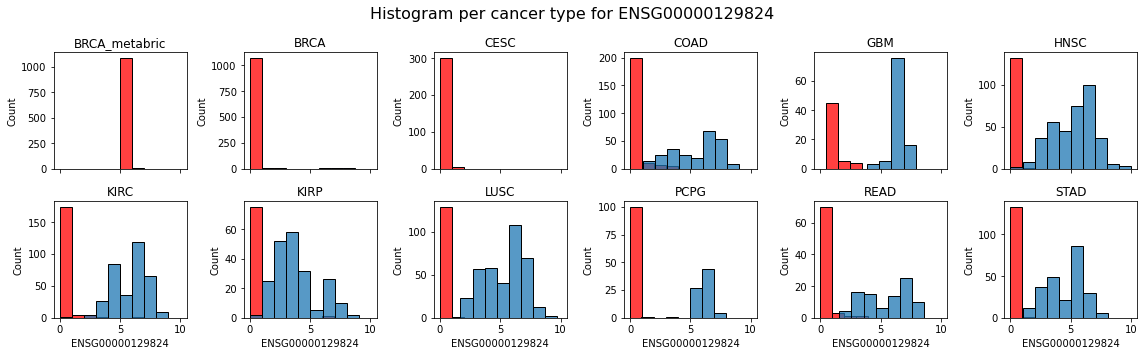

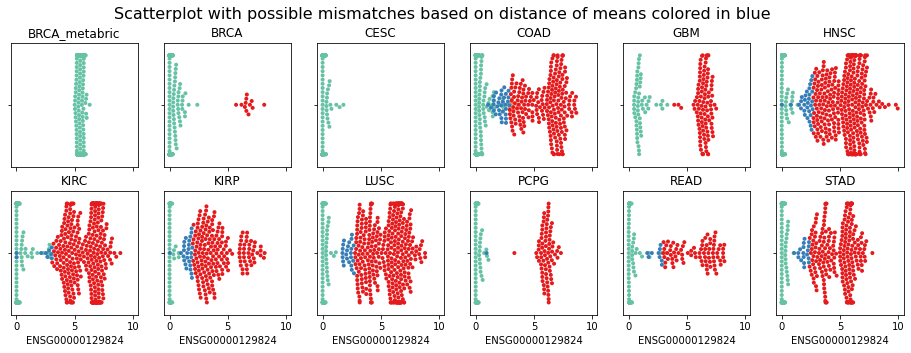

In [7]:
fig, axs = plt.subplots(2, 6, figsize=(16,5), sharex=True, sharey=False)
fig.suptitle(f'Histogram per cancer type for {gene}', fontsize=16)

fig2, axs2 = plt.subplots(2, 6, figsize=(16,5), sharex=True, sharey=False)
fig2.suptitle(f'Scatterplot with possible mismatches based on distance of means colored in blue', fontsize=16)

i = j = 0
for cohort in ct_sels_init:
    print(cohort)
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    try:
        pheno = pheno[pheno['gender.demographic'].notna()]
        pheno_data = pheno[pheno['gender.demographic'] != 'not reported']
        samples_f = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'female'].index.tolist()
        samples_m = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'male'].index.tolist()
    except:
        pheno = pheno[pheno['Sex'].notna()]
        samples_f = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Female'].index.tolist()
        samples_m = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Male'].index.tolist()
        
    expr_f = pd.DataFrame(expr.loc[samples_f][gene], columns=[gene])
    expr_m = pd.DataFrame(expr.loc[samples_m][gene], columns=[gene])

    expr_f['dev_f'] = abs(expr_f[gene] - expr_f[gene].mean())
    expr_f['dev_m'] = abs(expr_f[gene] - expr_m[gene].mean())
    expr_f['mismatch'] = expr_f['dev_m']<expr_f['dev_f']
    print('possible mismatches, females: ' + str(len(expr_f[expr_f['mismatch']])))

    expr_m['dev_m'] = abs(expr_m[gene] - expr_m[gene].mean())
    expr_m['dev_f'] = abs(expr_m[gene] - expr_f[gene].mean())
    expr_m['mismatch'] = expr_m['dev_f']<expr_m['dev_m']
    print('possible mismatches, men: ' + str(len(expr_m[expr_m['mismatch']])))
    
    print('\nmax female: ' + str(expr_f[gene].max()))
    print('min male: ' + str(expr_m[gene].min()))
    
    sns.histplot(expr.loc[samples_f][gene], binwidth=1, kde=False, ax=axs[j,i], color='red')
    sns.histplot(expr.loc[samples_m][gene], binwidth=1, kde=False, ax=axs[j,i])
    axs[j,i].title.set_text(cohort)

    sns.swarmplot(expr_f, x=gene, ax=axs2[j,i], hue='mismatch', palette=sns.color_palette("Set2"), size=4, legend=False)
    sns.swarmplot(expr_m, x=gene, ax=axs2[j,i], hue='mismatch', palette=sns.color_palette("Set1"), size=4, legend=False)
    axs2[j,i].title.set_text(cohort)

    i += 1
    if i == 6:
        i = 0
        j += 1
    print('\n')
        
fig.tight_layout()


TODO: herausfinden, wie in modmatcher der threshold 10 als Trennung zwischen male und female festgelegt wurde

### Ab hier am besten nicht mehr beachten ;)

BRCA_metabric
0
0


BRCA
1084
0


CESC
0
0


COAD
221
0


GBM
54
0


HNSC
133
0


KIRC
186
0


KIRP
76
0


LUSC
130
0


PCPG
101
0


READ
75
0


STAD
134
0




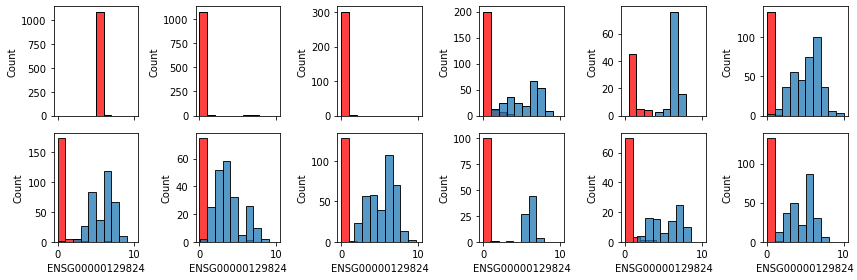

In [5]:
fig, axs = plt.subplots(2, 6, figsize=(12,4), sharex=True, sharey=False)
i = j = 0
for cohort in ct_sels_init:
    print(cohort)
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    try:
        pheno = pheno[pheno['gender.demographic'].notna()]
        pheno_data = pheno[pheno['gender.demographic'] != 'not reported']
        samples_f = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'female'].index.tolist()
        samples_m = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'male'].index.tolist()
    except:
        pheno = pheno[pheno['Sex'].notna()]
        samples_f = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Female'].index.tolist()
        samples_m = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Male'].index.tolist()
        
    expr_f = pd.DataFrame(expr.loc[samples_f][gene], columns=[gene])
    expr_m = pd.DataFrame(expr.loc[samples_m][gene], columns=[gene])

    expr_f['z_f'] = (expr_f[gene] - expr_f[gene].mean())/expr_f[gene].std(ddof=0)
    expr_f['z_m'] = (expr_f[gene] - expr_m[gene].mean())/expr_f[gene].std(ddof=0)
    print(len(expr_f[expr_f['z_m']<expr_f['z_f']]))

    expr_m['z_m'] = (expr_m[gene] - expr_m[gene].mean())/expr_m[gene].std(ddof=0)
    expr_m['z_f'] = (expr_m[gene] - expr_f[gene].mean())/expr_m[gene].std(ddof=0)
    print(len(expr_m[expr_m['z_f']<expr_m['z_m']]))
    
    sns.histplot(expr.loc[samples_f][gene], binwidth=1, kde=False, ax=axs[j,i], color='red')
    sns.histplot(expr.loc[samples_m][gene], binwidth=1, kde=False, ax=axs[j,i])

    i += 1
    if i == 6:
        i = 0
        j += 1
    print('\n')
        
fig.tight_layout()